In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from datetime import datetime
import time


from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [5]:
df.shape

(45773, 21)

In [2]:
# loading data from our data into a dataframe
df = pd.read_csv("results.csv")
# displaying the first few items of our dataframe
df.head()

,date,team_1,team_2,_map,result_1,result_2,map_winner,starting_ct,ct_1,t_2,t_1,ct_2,event_id,match_id,rank_1,rank_2,map_wins_1,map_wins_2,match_winner
0,2020-03-18,Recon 5,TeamOne,Dust2,0,16,2,2,0,1,0,15,5151,2340454,62,63,0,2,2
1,2020-03-18,Recon 5,TeamOne,Inferno,13,16,2,2,8,6,5,10,5151,2340454,62,63,0,2,2
2,2020-03-18,New England Whalers,Station7,Inferno,12,16,2,1,9,6,3,10,5243,2340461,140,118,12,16,2
3,2020-03-18,Rugratz,Bad News Bears,Inferno,7,16,2,2,0,8,7,8,5151,2340453,61,38,0,2,2
4,2020-03-18,Rugratz,Bad News Bears,Vertigo,8,16,2,2,4,5,4,11,5151,2340453,61,38,0,2,2


In [3]:
df['MapWinner'] = df.apply(lambda row: row.team_2 if row.map_winner == 2 else row.team_1, axis = 1)
df['SeriesWinner'] = df.apply(lambda row: row.team_2 if row.match_winner == 2 else row.team_1, axis = 1)

In [4]:
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df.apply(lambda row: row.date.year, axis = 1)
df = df.drop('date',1)

/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/327066870.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('date',1)


In [6]:
# cleaning up data
df = df.drop('starting_ct',1)
df = df.drop('result_1',1)
df = df.drop('result_2',1)
df = df.drop('map_wins_1',1)
df = df.drop('map_wins_2',1)
df = df.drop('event_id',1)

#df = df.loc[df['rank_1'] <= 10]
#df = df.loc[df['rank_2'] <= 10]


df = df.drop('map_winner',1)
df = df.drop('match_winner',1)
df.rename(columns = {'_map':'Map','team_1':'Team_One','team_2':'Team_Two','rank_1':'Team_Ones_Rank','rank_2': 'Team_Twos_Rank', \
                    'ct_1': 'Team_One_CT_Rounds','t_2': 'Team_Two_T_Rounds', 't_1':'Team_One_T_Rounds', 'ct_2':'Team_Two_CT_Rounds'}, inplace = True)
df = df.sort_values(by = 'match_id', ascending = False)
df = df.reset_index(drop = True)
df.head()

/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3800810102.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('starting_ct',1)
/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3800810102.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('result_1',1)
/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3800810102.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('result_2',1)
/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3800810102.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop('map_wins_1',1)
/var/folders/_t/pqhgzhk

,Team_One,Team_Two,Map,Team_One_CT_Rounds,Team_Two_T_Rounds,Team_One_T_Rounds,Team_Two_CT_Rounds,match_id,Team_Ones_Rank,Team_Twos_Rank,MapWinner,SeriesWinner,Year
0,New England Whalers,Station7,Inferno,9,6,3,10,2340461,140,118,Station7,Station7,2020
1,Singularity,Endpoint,Overpass,8,6,5,10,2340456,71,41,Endpoint,Endpoint,2020
2,Singularity,Endpoint,Vertigo,6,9,5,7,2340456,71,41,Endpoint,Endpoint,2020
3,Espada,Tricked,Dust2,3,8,13,2,2340455,56,77,Espada,Espada,2020
4,Espada,Tricked,Nuke,7,8,9,2,2340455,56,77,Espada,Espada,2020


In [7]:
df.shape

(45773, 13)

In [8]:
df.to_csv("results_cleaned.csv", index=False)

In [22]:
# cleaning up the player data
player_df = pd.read_csv("players.csv")
player_df.head()

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,...,m3_kddiff_ct,m3_adr_ct,m3_kast_ct,m3_rating_ct,m3_kills_t,m3_deaths_t,m3_kddiff_t,m3_adr_t,m3_kast_t,m3_rating_t
0,2020-02-26,Brehze,Evil Geniuses,Liquid,United States,9136,2339385,4901,IEM Katowice 2020,3,...,-1.0,72.5,80.0,0.93,7.0,9.0,-2.0,70.4,63.6,0.89
1,2020-02-26,CeRq,Evil Geniuses,Liquid,Bulgaria,11219,2339385,4901,IEM Katowice 2020,3,...,3.0,79.5,53.3,1.12,4.0,8.0,-4.0,40.7,54.5,0.53
2,2020-02-26,EliGE,Liquid,Evil Geniuses,United States,8738,2339385,4901,IEM Katowice 2020,3,...,1.0,81.5,63.6,1.03,9.0,9.0,0.0,87.9,73.3,1.05
3,2020-02-26,Ethan,Evil Geniuses,Liquid,United States,10671,2339385,4901,IEM Katowice 2020,3,...,0.0,67.2,66.7,0.97,1.0,9.0,-8.0,14.8,45.5,0.31
4,2020-02-26,NAF,Liquid,Evil Geniuses,Canada,8520,2339385,4901,IEM Katowice 2020,3,...,-1.0,72.9,81.8,0.96,8.0,7.0,1.0,56.3,80.0,0.99


In [26]:
player_df['player_name'].nunique()

11991

In [ ]:
# Identifying columns with '_x' and '_y' suffixes
duplicate_columns = [col for col in player_df.columns if '_rating_t' in col]

# Displaying the identified columns with duplicates
duplicate_columns

In [11]:
player_df = player_df[['player_name','team', 'match_id', 'm1_rating_ct', 'm1_rating_t', 'm2_rating_ct', \
                       'm2_rating_t','m3_rating_ct', 'm3_rating_t']]
#, 'm3_rating_ct', 'm3_rating_t'
player_df = player_df.dropna(subset=['m1_rating_ct', 'm1_rating_t', 'm2_rating_ct','m2_rating_t'])

player_df.shape

(127934, 9)

In [12]:
player_df['Average_T_Rating'] = player_df[['m1_rating_t', 'm2_rating_t', 'm3_rating_t']].mean(axis=1)
#player_df['Average_T_kills'] = player_df['m1_kills_t', 'm2_kills_t', 'm3_kills_t']
player_df['Average_CT_Rating'] = player_df[['m1_rating_ct', 'm2_rating_ct', 'm3_rating_ct']].mean(axis=1)

player_df = player_df.drop(['m1_rating_ct','m1_rating_t', 'm2_rating_ct','m2_rating_t','m3_rating_ct',\
                            'm3_rating_t'],1)
player_df.rename(columns = {'player_name': 'Player', 'team': 'Team'}, inplace = True)


/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/353325237.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  player_df = player_df.drop(['m1_rating_ct','m1_rating_t', 'm2_rating_ct','m2_rating_t','m3_rating_ct',\


In [24]:
player_df.sample(10000).to_csv('player_10k.csv', index=False)

In [ ]:
# creating a new dataframe by merging
new_df = pd.merge(player_df,df,on = 'match_id')
new_df = new_df.sort_values(by = 'match_id', ascending = False)
new_df = new_df.reset_index(drop = True)
new_df = new_df.drop('match_id',1)
new_df = new_df.drop('Year',1)
"""
new_df = new_df.loc[new_df['Team'] != 'Renegades']
new_df = new_df.loc[new_df['Team'] != 'North']
new_df = new_df.loc[new_df['Team'] != 'NiP']
new_df = new_df.loc[new_df['Team'] != 'Gambit']
new_df = new_df.loc[new_df['Team'] != 'BIG']
new_df = new_df.loc[new_df['Team'] != 'NRG']
new_df = new_df.loc[new_df['Team'] != 'SK']
new_df = new_df.loc[new_df['Team'] != 'G2']
"""
new_df.head()

In [17]:
merged_cleaned_data.shape

(302411, 17)

In [16]:
# Merging the player data with the results data on 'match_id'
merged_cleaned_data = pd.merge(player_df, df, on='match_id')

merged_cleaned_data.head()

,Player,Team,match_id,Average_T_Rating,Average_CT_Rating,Team_One,Team_Two,Map,Team_One_CT_Rounds,Team_Two_T_Rounds,Team_One_T_Rounds,Team_Two_CT_Rounds,Team_Ones_Rank,Team_Twos_Rank,MapWinner,SeriesWinner,Year
0,Brehze,Evil Geniuses,2339385,0.860000,1.08,Liquid,Evil Geniuses,Inferno,7,4,9,6,3,5,Liquid,Liquid,2020
1,Brehze,Evil Geniuses,2339385,0.860000,1.08,Liquid,Evil Geniuses,Nuke,11,4,4,11,3,5,Evil Geniuses,Liquid,2020
2,Brehze,Evil Geniuses,2339385,0.860000,1.08,Liquid,Evil Geniuses,Overpass,7,1,9,6,3,5,Liquid,Liquid,2020
3,CeRq,Evil Geniuses,2339385,0.676667,1.15,Liquid,Evil Geniuses,Inferno,7,4,9,6,3,5,Liquid,Liquid,2020
4,CeRq,Evil Geniuses,2339385,0.676667,1.15,Liquid,Evil Geniuses,Nuke,11,4,4,11,3,5,Evil Geniuses,Liquid,2020


In [18]:
# Feature Engineering
# Creating a rank difference feature
merged_cleaned_data['Rank_Difference'] = abs(merged_cleaned_data['Team_Ones_Rank'] - merged_cleaned_data['Team_Twos_Rank'])

# Creating a binary feature for whether the player's team won the map
merged_cleaned_data['Player_Team_Won'] = (merged_cleaned_data['Team'] == merged_cleaned_data['MapWinner']).astype(int)

# Including map-specific information (one-hot encoding)
map_dummies = pd.get_dummies(merged_cleaned_data['Map'], prefix='Map')

# Adding the new features to the dataset
merged_cleaned_data = pd.concat([merged_cleaned_data, map_dummies], axis=1)


In [19]:
# Selecting features for the model
model_features = ['Average_CT_Rating', 'Rank_Difference', 'Player_Team_Won'] + list(map_dummies.columns)
target = 'Average_T_Rating'  # Target variable (you can change this to 'Average_CT_Rating' or other metrics as needed)

# Preparing the data for the model
X = merged_cleaned_data[model_features]
y = merged_cleaned_data[target]

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initializing additional models
models.update({
    "Gradient Boosting Regressor": GradientBoostingRegressor()
})

# Re-training and evaluating each model with the new features
for name, model in models.items():
    model.fit(X_train, y_train)  # Training the model
    y_pred = model.predict(X_test)  # Predicting on the test set
    mse = mean_squared_error(y_test, y_pred)  # Calculating MSE
    r2 = r2_score(y_test, y_pred)  # Calculating R-squared
    model_performance[name] = {"MSE": mse, "R2": r2}

model_performance

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Initializing the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

# Dictionary to store the performance metrics of each model
model_performance = {}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Training the model
    y_pred = model.predict(X_test)  # Predicting on the test set
    mse = mean_squared_error(y_test, y_pred)  # Calculating MSE
    r2 = r2_score(y_test, y_pred)  # Calculating R-squared
    model_performance[name] = {"MSE": mse, "R2": r2}

model_performance


{'Linear Regression': {'MSE': 0.09644434630084472, 'R2': 0.16147920604489197},
 'Ridge Regression': {'MSE': 0.09644433979652699, 'R2': 0.16147926259569956},
 'Lasso Regression': {'MSE': 0.11501745968220213,
  'R2': -1.9214249682431017e-06},
 'Decision Tree Regressor': {'MSE': 0.16566363894277591,
  'R2': -0.4403374732041927},
 'Random Forest Regressor': {'MSE': 0.11086087294369414,
  'R2': 0.03613689381719032},
 'Gradient Boosting Regressor': {'MSE': 0.09586071882088933,
  'R2': 0.16655346696983675}}

In [ ]:
gc.collect()

In [ ]:
players_data = pd.read_csv('players.csv')
results_data = pd.read_csv('results.csv')

In [ ]:
# Merging the player data with the results data
merged_data = pd.merge(players_data, results_data, on='match_id')

merged_data.head()

In [ ]:
merged_data.shape

In [ ]:
# Determining if the player's team won or lost each match
# We assume that if the player's team is 'team_1' and 'map_winner' is 1, 
#or if the player's team is 'team_2' and 'map_winner' is 2, 
#then the player's team won
merged_data['player_team_win'] = ((merged_data['team'] == merged_data['team_1']) & (merged_data['map_winner'] == 1)) | ((merged_data['team'] == merged_data['team_2']) & (merged_data['map_winner'] == 2))

# Convert 'player_team_win' to a more readable format (Win or Loss)
merged_data['match_outcome'] = merged_data['player_team_win'].apply(lambda x: 'Win' if x else 'Loss')

# Displaying the first few rows of the merged dataset to verify the join and new columns
merged_data[['player_name', 'team', 'opponent', 'match_id', 'map_winner', 'player_team_win', 'match_outcome']].head()


In [ ]:
# Aggregating player performance metrics for each player in wins and losses
performance_columns = ['kills', 'deaths', 'assists', 'adr', 'kast', 'rating']

# Aggregating metrics for wins
performance_win = merged_data[merged_data['match_outcome'] == 'Win'].groupby('player_name')[performance_columns].mean().add_suffix('_win')

# Aggregating metrics for losses
performance_loss = merged_data[merged_data['match_outcome'] == 'Loss'].groupby('player_name')[performance_columns].mean().add_suffix('_loss')

# Merging the win and loss performance metrics
player_performance_comparison = performance_win.merge(performance_loss, on='player_name')

# Displaying the first few rows of the aggregated performance comparison
player_performance_comparison.head()


In [ ]:
player_performance_comparison

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

features = ['kills_win', 'deaths_win', 'assists_win', 'adr_win', 'kast_win']
target = 'rating_win'

# Preparing the data
X = player_performance_comparison[features]
y = player_performance_comparison[target]

# Handling any missing values by dropping them
X.dropna(inplace=True)
y = y[X.index]  # Ensuring the target aligns with the features after dropping missing values

# Splitting the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing the Linear Regression model
model = LinearRegression()

# Training the model
model.fit(X_train, y_train)

# Predicting on the test set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)

mse


In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Initializing the models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor()
}

# Dictionary to store the performance metrics of each model
model_performance = {}

# Training and evaluating each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Training the model
    y_pred = model.predict(X_test)  # Predicting on the test set
    mse = mean_squared_error(y_test, y_pred)  # Calculating MSE
    r2 = r2_score(y_test, y_pred)  # Calculating R-squared
    model_performance[name] = {"MSE": mse, "R2": r2}

model_performance


In [28]:
data = pd.read_csv("results.csv")

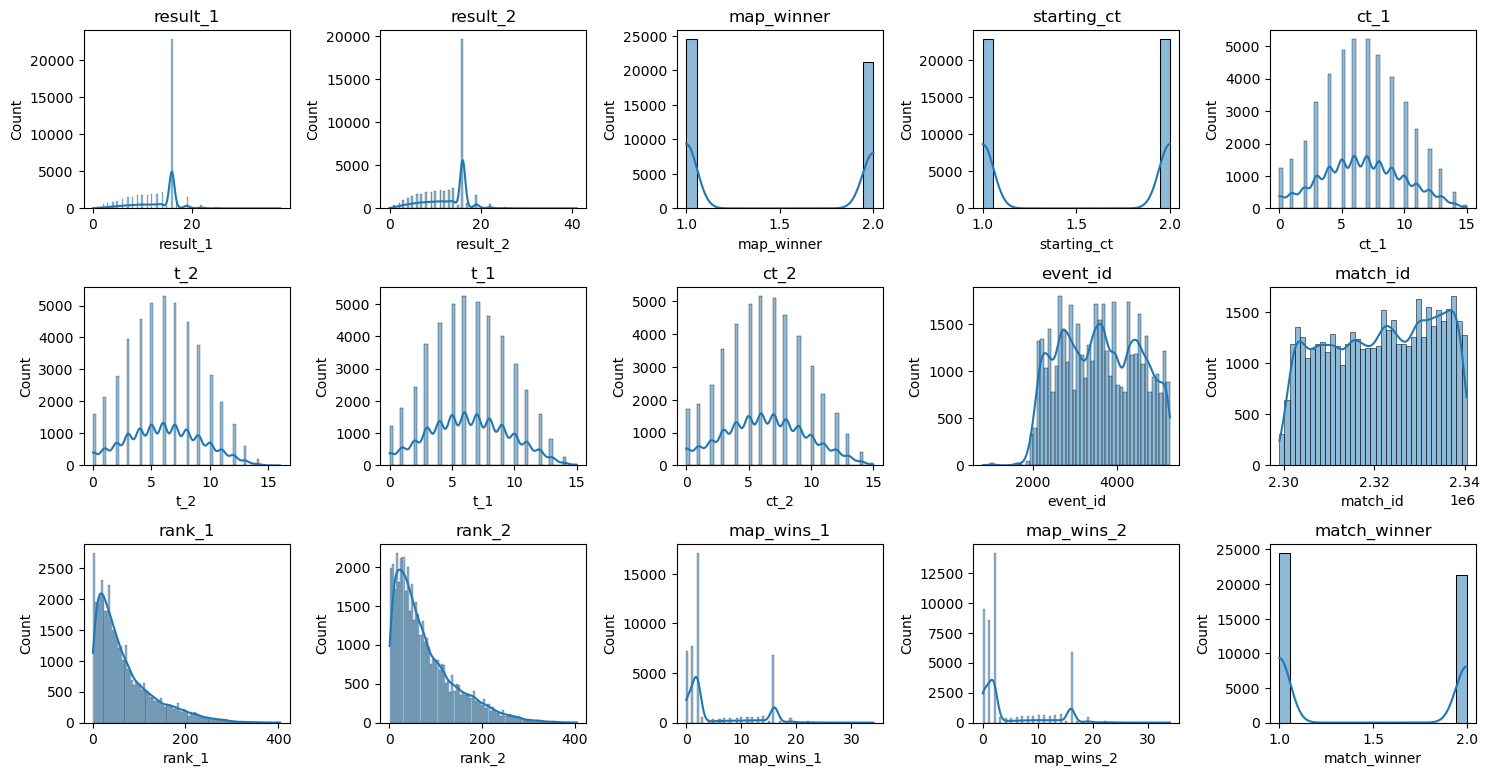

(           result_1      result_2    map_winner   starting_ct          ct_1  \
 count  45773.000000  45773.000000  45773.000000  45773.000000  45773.000000   
 mean      13.385489     12.731545      1.462478      1.501387      6.659515   
 std        4.417713      4.715722      0.498596      0.500004      3.257815   
 min        0.000000      0.000000      1.000000      1.000000      0.000000   
 25%       11.000000      9.000000      1.000000      1.000000      4.000000   
 50%       16.000000     16.000000      1.000000      2.000000      7.000000   
 75%       16.000000     16.000000      2.000000      2.000000      9.000000   
 max       38.000000     41.000000      2.000000      2.000000     15.000000   
 
                 t_2           t_1          ct_2      event_id      match_id  \
 count  45773.000000  45773.000000  45773.000000  45773.000000  4.577300e+04   
 mean       6.057283      6.375571      6.335482   3580.790859  2.321278e+06   
 std        3.161310      3.184036    

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting numerical columns for distribution analysis
numerical_cols = data.select_dtypes(include=['int64'])

# Summary statistics of numerical columns
numerical_summary = numerical_cols.describe()

# Plotting distributions of numerical columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols.columns):
    plt.subplot(4, 5, i + 1)
    sns.histplot(numerical_cols[col], kde=True)
    plt.title(col)
    plt.tight_layout()

numerical_summary, plt.show()  # Show summary statistics and plots


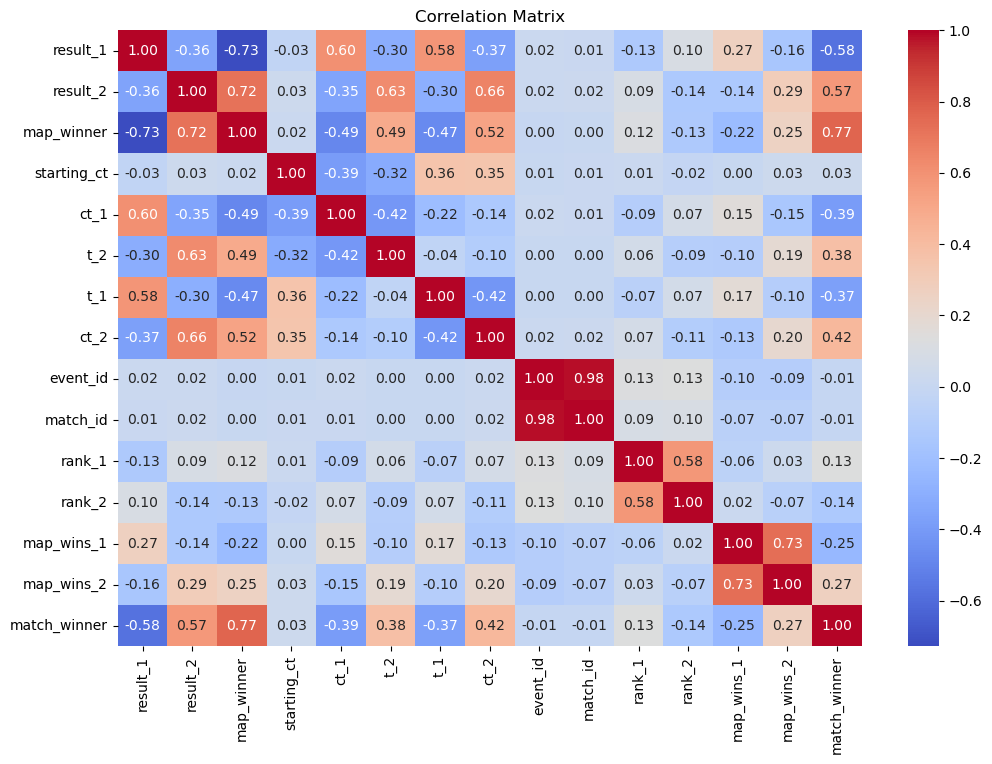

In [30]:
# Correlation analysis
correlation_matrix = numerical_cols.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


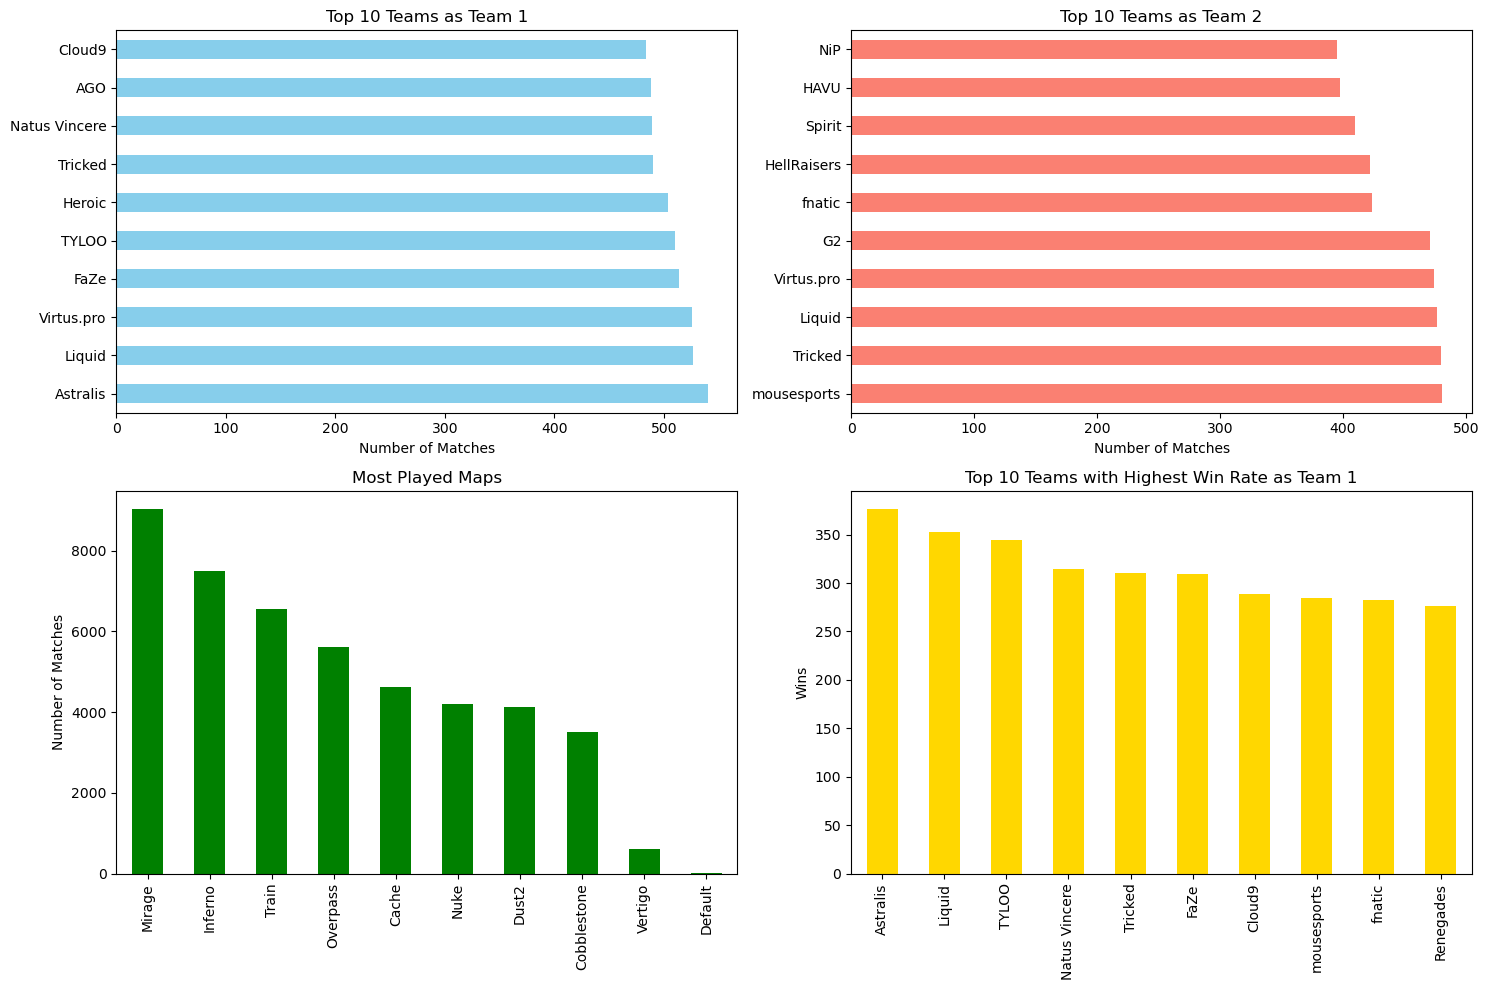

(Astralis         540
 Liquid           527
 Virtus.pro       526
 FaZe             514
 TYLOO            510
 Heroic           504
 Tricked          490
 Natus Vincere    489
 AGO              488
 Cloud9           484
 Name: team_1, dtype: int64,
 mousesports    481
 Tricked        480
 Liquid         477
 Virtus.pro     474
 G2             471
 fnatic         424
 HellRaisers    422
 Spirit         410
 HAVU           398
 NiP            395
 Name: team_2, dtype: int64,
 Mirage      9021
 Inferno     7485
 Train       6566
 Overpass    5625
 Cache       4613
 Name: _map, dtype: int64,
 Astralis         376
 Liquid           353
 TYLOO            344
 Natus Vincere    314
 Tricked          310
 FaZe             309
 Cloud9           289
 mousesports      285
 fnatic           282
 Renegades        276
 Name: team_1, dtype: int64)

In [31]:
# Analysis of categorical data - Teams, Maps, Winners

# Top teams by number of matches played
top_teams_1 = data['team_1'].value_counts().head(10)
top_teams_2 = data['team_2'].value_counts().head(10)

# Most played maps
most_played_maps = data['_map'].value_counts()

# Win rates for teams as team_1 and team_2
team_1_win_rate = data[data['match_winner'] == 1]['team_1'].value_counts()
team_2_win_rate = data[data['match_winner'] == 2]['team_2'].value_counts()

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

top_teams_1.plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Top 10 Teams as Team 1')
axes[0, 0].set_xlabel('Number of Matches')

top_teams_2.plot(kind='barh', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Top 10 Teams as Team 2')
axes[0, 1].set_xlabel('Number of Matches')

most_played_maps.plot(kind='bar', ax=axes[1, 0], color='green')
axes[1, 0].set_title('Most Played Maps')
axes[1, 0].set_ylabel('Number of Matches')

team_1_win_rate.head(10).plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Top 10 Teams with Highest Win Rate as Team 1')
axes[1, 1].set_ylabel('Wins')

plt.tight_layout()
plt.show()

top_teams_1, top_teams_2, most_played_maps.head(), team_1_win_rate.head(10)


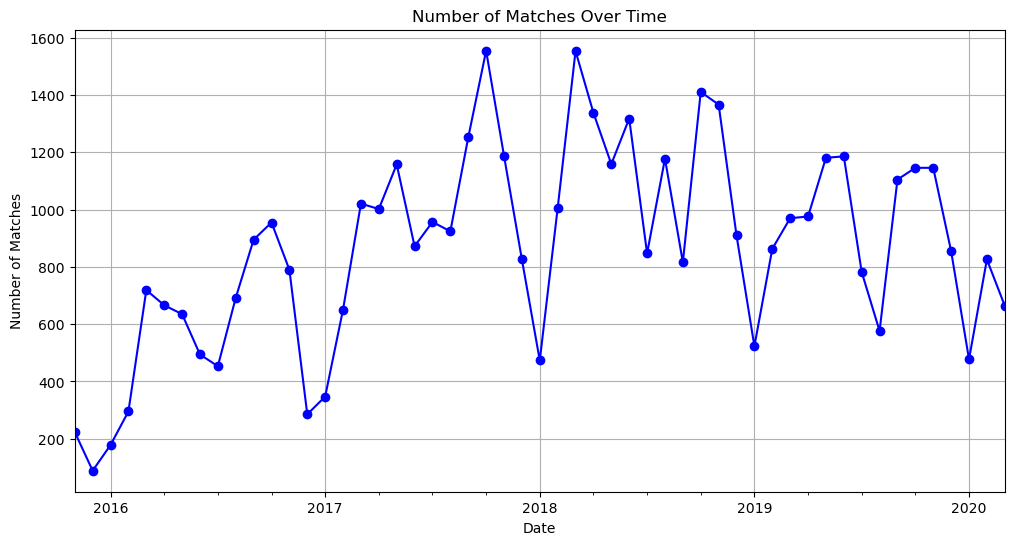

(count      53.000000
 mean      863.641509
 std       352.450602
 min        88.000000
 25%       651.000000
 50%       872.000000
 75%      1146.000000
 max      1555.000000
 dtype: float64,
 Timestamp('2017-10-31 00:00:00', freq='M'),
 Timestamp('2015-12-31 00:00:00', freq='M'))

In [32]:
# Converting 'date' to datetime and setting it as the index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Number of matches over time
matches_over_time = data.resample('M').size()

# Plotting the number of matches over time
plt.figure(figsize=(12, 6))
matches_over_time.plot(kind='line', color='blue', marker='o')
plt.title('Number of Matches Over Time')
plt.ylabel('Number of Matches')
plt.xlabel('Date')
plt.grid(True)
plt.show()

# Summary of matches over time
matches_over_time.describe(), matches_over_time.idxmax(), matches_over_time.idxmin()


In [33]:
# Creating a unified DataFrame for player performance across all maps
players_df = pd.read_csv('players.csv')
df = pd.DataFrame()

# Join all the individual maps played into one table
for i in [1, 2, 3]:
    player_columns = ['match_id', 'player_id', 'team', f'map_{i}',
                      f'm{i}_kills', f'm{i}_assists', f'm{i}_deaths', f'm{i}_hs', f'm{i}_flash_assists',
                      f'm{i}_kast', f'm{i}_kddiff', f'm{i}_adr', f'm{i}_fkdiff', f'm{i}_rating']
    temp_df = players_df[player_columns]
    # Rename the columns to exclude map index
    temp_df.columns = ['match_id', 'player_id', 'team', '_map',
                       'kills', 'assists', 'deaths', 'hs', 'flash_assists',
                       'kast', 'kddiff', 'adr', 'fkdiff', 'rating']
    temp_df = temp_df.dropna()
    df = df.append(temp_df)

# Display the first few rows of the unified DataFrame
df.head()


/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3974679114.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3974679114.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)
/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/3974679114.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(temp_df)


,match_id,player_id,team,_map,kills,assists,deaths,hs,flash_assists,kast,kddiff,adr,fkdiff,rating
0,2339385,9136,Evil Geniuses,Overpass,11.0,3.0,18.0,5.0,0.0,65.2,-7.0,60.8,-1.0,0.70
1,2339385,11219,Evil Geniuses,Overpass,11.0,2.0,17.0,4.0,2.0,60.9,-6.0,68.9,-1.0,0.75
2,2339385,8738,Liquid,Overpass,15.0,3.0,12.0,9.0,0.0,69.6,3.0,77.0,3.0,1.32
3,2339385,10671,Evil Geniuses,Overpass,11.0,1.0,15.0,6.0,1.0,65.2,-4.0,60.7,-2.0,0.73
4,2339385,8520,Liquid,Overpass,10.0,5.0,12.0,3.0,3.0,65.2,-2.0,51.5,0.0,0.83


/var/folders/_t/pqhgzhkx0s3dlljndz6jmysh0000gn/T/ipykernel_28363/196326907.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  performance_correlation = df.corr()


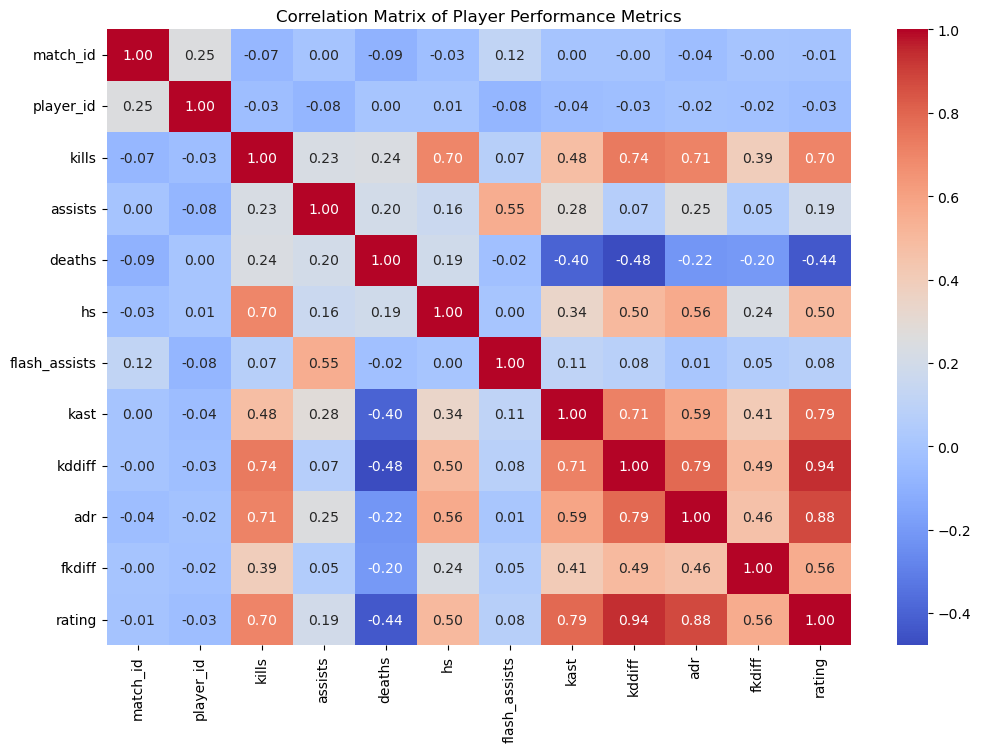

(           match_id      player_id          kills        assists  \
 count  4.487110e+05  448711.000000  448711.000000  448711.000000   
 mean   2.324660e+06   10274.943757      17.937824       4.422882   
 std    9.420263e+03    4344.464471       6.493651       2.538023   
 min    2.300200e+06       7.000000       0.000000       0.000000   
 25%    2.316812e+06    8302.000000      13.000000       3.000000   
 50%    2.325088e+06   10394.000000      18.000000       4.000000   
 75%    2.332772e+06   13230.000000      22.000000       6.000000   
 max    2.339828e+06   20011.000000      76.000000      23.000000   
 
               deaths             hs  flash_assists           kast  \
 count  448711.000000  448711.000000  448711.000000  448711.000000   
 mean       17.963881       8.133304       0.996597      69.367982   
 std         4.989067       3.918669       1.303692      12.143653   
 min         0.000000       0.000000       0.000000       5.600000   
 25%        15.000000      

In [34]:
# Descriptive Statistics of the unified DataFrame
performance_summary = df.describe()

# Correlation Analysis
performance_correlation = df.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(performance_correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Player Performance Metrics")
plt.show()

performance_summary, performance_correlation  # Display summary and correlation matrix


In [43]:
df['player_id'].nunique()

10119

In [45]:
data['event_id'].nunique()

2363

In [37]:
data.columns.tolist()

['team_1',
 'team_2',
 '_map',
 'result_1',
 'result_2',
 'map_winner',
 'starting_ct',
 'ct_1',
 't_2',
 't_1',
 'ct_2',
 'event_id',
 'match_id',
 'rank_1',
 'rank_2',
 'map_wins_1',
 'map_wins_2',
 'match_winner']

In [ ]:
data